In [46]:
# Import libraries
from __future__ import print_function
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# Example dimensions (replace with real dimensions)
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

#inputting data



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# Example dimensions (replace with real dimensions)
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

#inputting data



class LexicalDataset(Dataset):
    def __init__(self, data, item_dict, rel_dict, attr_dict):
        """
        Args:
            csv_file (str): Path to the CSV file with columns: item, relation, attribute, validity
            item_dict (dict): Maps item_name -> integer index
            rel_dict (dict): Maps relation_name -> integer index
            attr_dict (dict): Maps attribute_name -> integer index
        """
        self.data = data
        self.item_dict = item_dict
        self.rel_dict = rel_dict
        self.attr_dict = attr_dict
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        item_name = row['Item']
        rel_name = row['Relation']
        attr_name = row['Attribute']
        validity = row['Validity']
        if(pd.isnull(item_name)):
            print(idx)
        # Convert item to one-hot
        item_vec = torch.zeros(nobj)
        item_idx = self.item_dict[item_name]
        item_vec[item_idx] = 1.0
        
        # Convert relation to one-hot
        rel_vec = torch.zeros(nrel)
        rel_idx = self.rel_dict[rel_name]
        rel_vec[rel_idx] = 1.0
        
        # Convert attribute to one-hot
        attr_vec = torch.zeros(nattr)
        attr_idx = self.attr_dict[attr_name]
        attr_vec[attr_idx] = 1.0
        
        # validity is assumed to be 0 or 1
        y = torch.tensor([validity], dtype=torch.float)
        
        return item_vec, rel_vec, attr_vec, y

# -------------------------------------------------------
# Example of how to set up the dictionaries:
# If your CSV contains columns with known sets of item, relation, and attribute names,
# you can build dicts based on the unique values found in the CSV.
#
# Alternatively, if you already know the fixed sets and ordering, you can hard-code them.
# For example:
with open("data/sem_items.txt", "r") as fid:
    items = np.array([l.strip() for l in fid.readlines()])
with open("data/sem_relations.txt", "r") as fid:
    relations = np.array([l.strip() for l in fid.readlines()])
with open("data/sem_attributes.txt", "r") as fid:
    attributes = np.array([l.strip() for l in fid.readlines()])

# Define sizes
nobj = 8       # number of items
nrel = 4       # number of relations
nattr = 36     # number of attributes

item_dict = {name: i for i, name in enumerate(items)}
rel_dict = {name: i for i, name in enumerate(relations)}
attr_dict = {name: i for i, name in enumerate(attributes)}

# -------------------------------------------------------
# Create the dataset and dataloader
#--------------------------------------------------------
data=pd.read_csv('lexical_data.csv')
validity_0 = data[data['Validity'] == 0]
validity_1 = data[data['Validity'] == 1]

# Randomly select 200 rows from the validity_0 set
validity_0_sampled = validity_0.sample(n=200)

# Combine the sampled validity_0 data with all validity_1 data
combined_data = pd.concat([validity_0_sampled, validity_1], ignore_index=True)

# Shuffle the combined dataset
shuffled_data = combined_data.sample(frac=1).reset_index(drop=True)
dataset = LexicalDataset(shuffled_data, item_dict, rel_dict, attr_dict)

# Example: create a DataLoader for training
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

class SemanticCognitionRNN(nn.Module):
    def __init__(self, nobj, nrel, nattr, hidden_size=48, num_layers=1):
        super(SemanticCognitionRNN, self).__init__()
        
        self.nobj = nobj
        self.nrel = nrel
        self.nattr = nattr
        self.hidden_size = hidden_size
        
        self.item2rep = nn.Linear(nobj, nobj)
        self.rel2rep = nn.Linear(nrel, nrel)
        self.attr2rep = nn.Linear(nattr, nattr)
        
        self.rnn = nn.GRU(input_size=hidden_size, hidden_size=64, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(64, 1)
        
    def forward(self, x_item, x_rel, x_attr):
        # Compute representations
        item_rep = F.relu(self.item2rep(x_item))   # [B, hidden_size]
        rel_rep  = F.relu(self.rel2rep(x_rel))     # [B, hidden_size]
        attr_rep = F.relu(self.attr2rep(x_attr))   # [B, hidden_size]
        
        # Create sequence [item_rep, rel_rep, attr_rep]
        seq = torch.cat([item_rep, rel_rep, attr_rep], dim=1)   # [B, 3, hidden_size]
        
        out, h = self.rnn(seq)  # [B, 3, hidden_size]
        # last_hidden = out[:, -1, :]  # [B, hidden_size]
        
        logits = self.fc(out)
        probs = torch.sigmoid(logits)
        
        # Return probs and item_rep (similar to the original Net)
        return probs, item_rep

# -----------------
# Training function
# -----------------

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10, print_every=100):
    """
    Train the SemanticCognitionRNN model.

    Args:
        model (nn.Module): Your SemanticCognitionRNN model.
        train_loader (DataLoader): PyTorch DataLoader yielding batches of (x_item, x_rel, x_attr, y).
        criterion (nn.Module): Loss function (e.g. nn.BCELoss()).
        optimizer (torch.optim.Optimizer): Optimizer (e.g. Adam).
        device (torch.device): CPU or GPU device.
        num_epochs (int): Number of epochs to train.
        print_every (int): Print loss every 'print_every' batches.

    Returns:
        model (nn.Module): The trained model.
    """

    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (x_item, x_rel, x_attr, y) in enumerate(train_loader, start=1):
            # Move data to device
            x_item = x_item.to(device)
            x_rel = x_rel.to(device)
            x_attr = x_attr.to(device)
            y = y.to(device)

            # Forward pass
            outputs,_= model(x_item, x_rel, x_attr)  # outputs: [B, 1]
            
            # Compute loss
            loss = criterion(outputs, y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Print training info
            if batch_idx % print_every == 0:
                avg_loss = running_loss / print_every
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}], Loss: {avg_loss:.4f}')
                running_loss = 0.0

    return model



def get_rep(model):
    # Create one-hot vectors for each item
    input_clean = torch.zeros(nobj, nobj).to(device)
    for idx in range(nobj):
        input_clean[idx, idx] = 1.0  # one-hot for the item
    
    # We'll create dummy relation and attribute inputs, since we only want item_rep
    x_rel_dummy = torch.zeros(nobj, nrel).to(device)
    x_attr_dummy = torch.zeros(nobj, nattr).to(device)
    
    with torch.no_grad():
        # Forward pass through the model
        # We don't care about the output probs here, just the item_rep
        _, rep = model(input_clean, x_rel_dummy, x_attr_dummy)
    return rep.detach().cpu().numpy()


# -----------------
# Dummy Data for Demonstration
# -----------------

learning_rate=0.1

model = SemanticCognitionRNN(nobj, nrel, nattr)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# -----------------
# Training Loop (Dummy)
# -----------------
nepochs_phase1 = 200
nepochs_phase2 = 600
nepochs_phase3 = 1000
epoch_count = 0

epoch_count = train_model(model,train_loader,criterion,optimizer,device,200,50)
rep1 = get_rep(model)

# Phase 2 Training
epoch_count = train_model(model,train_loader,criterion,optimizer,device,400,50)
rep2 = get_rep(model)

# Phase 3 Training
epoch_count =  train_model(model,train_loader,criterion,optimizer,device,400,50)
rep3 = get_rep(model)


# -----------------
# Plot graph function
# -----------------

def plot_rep(rep1, rep2, rep3, names):
    """
    Plot bar graphs comparing representations at different training phases.
    rep1, rep2, rep3: [nobj, rep_size]
    names: list of item names
    """
    nepochs_list = [nepochs_phase1, nepochs_phase2, nepochs_phase3]  # define these if you do phase-wise training
    R = np.dstack((rep1, rep2, rep3))  # [nobj, rep_size,3]
    print(R.shape)
    mx = R.max()
    mn = R.min()
    depth = R.shape[2]
    nobj = R.shape[0]

    plt.figure(figsize=(4.2, 8.4))
    count = 1
    for i in range(nobj):
        for d in range(depth):
            plt.subplot(nobj, depth, count)
            plt.bar(range(R.shape[1]), R[i, :, d])
            plt.ylim([mn, mx])
            plt.xticks([])
            plt.yticks([])
            if d == 0:
                plt.ylabel(names[i], fontsize=8)
            if i == 0:
                plt.title(f"Epoch {nepochs_list[d]}", fontsize=8)
            count += 1
    plt.tight_layout()
    plt.show()
    # plt.savefig("image/bar_graph")

def plot_dendo(rep1, rep2, rep3, names):
    """
    Plot dendrograms comparing hierarchical clustering of representations at different epochs.
    """
    nepochs_list = [nepochs_phase1, nepochs_phase2, nepochs_phase3]
    linked1 = linkage(rep1, "single")
    linked2 = linkage(rep2, "single")
    linked3 = linkage(rep3, "single")
    mx = max(linked1[:, 2].max(), linked2[:, 2].max(), linked3[:, 2].max()) + 0.1
    plt.figure(figsize=(7, 12))
    for i, (linked, epoch) in enumerate(zip([linked1, linked2, linked3], nepochs_list), 1):
        plt.subplot(3, 1, i)
        dendrogram(linked, labels=names, color_threshold=0)
        plt.ylim([0, mx])
        plt.title(f"Hierarchical Clustering - Epoch {epoch}")
        plt.ylabel("Euclidean Distance")
    plt.tight_layout()
    plt.show()
    # plt.savefig("image/dendographs.jpg")

Epoch [1/200], Step [50], Loss: 0.6958
Epoch [2/200], Step [50], Loss: 0.6918
Epoch [3/200], Step [50], Loss: 0.6950
Epoch [4/200], Step [50], Loss: 0.6958
Epoch [5/200], Step [50], Loss: 0.6945
Epoch [6/200], Step [50], Loss: 0.6935
Epoch [7/200], Step [50], Loss: 0.6883
Epoch [8/200], Step [50], Loss: 0.6828
Epoch [9/200], Step [50], Loss: 0.6705
Epoch [10/200], Step [50], Loss: 0.6560
Epoch [11/200], Step [50], Loss: 0.6469
Epoch [12/200], Step [50], Loss: 0.6128
Epoch [13/200], Step [50], Loss: 0.6085
Epoch [14/200], Step [50], Loss: 0.5722
Epoch [15/200], Step [50], Loss: 0.5453
Epoch [16/200], Step [50], Loss: 0.5464
Epoch [17/200], Step [50], Loss: 0.5558
Epoch [18/200], Step [50], Loss: 0.5310
Epoch [19/200], Step [50], Loss: 0.5537
Epoch [20/200], Step [50], Loss: 0.5465
Epoch [21/200], Step [50], Loss: 0.5709
Epoch [22/200], Step [50], Loss: 0.4869
Epoch [23/200], Step [50], Loss: 0.5485
Epoch [24/200], Step [50], Loss: 0.5134
Epoch [25/200], Step [50], Loss: 0.5389
Epoch [26

In [51]:
nepochs_phase1 = 200
nepochs_phase2 = 600
nepochs_phase3 = 1000

(8, 8, 3)


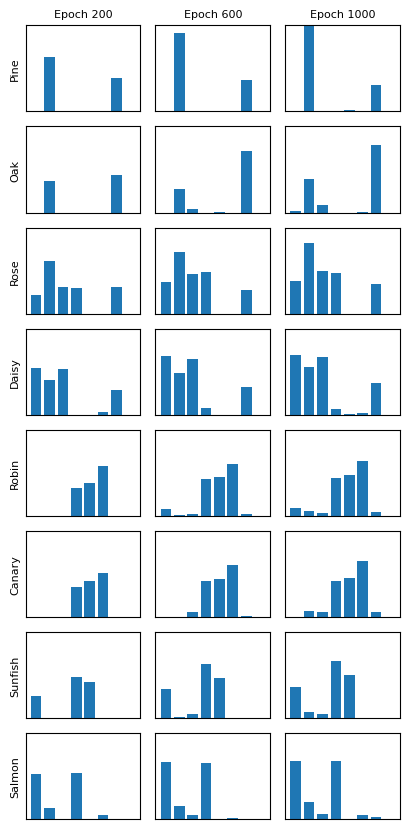

In [52]:
plot_rep(rep1,rep2,rep3,items)

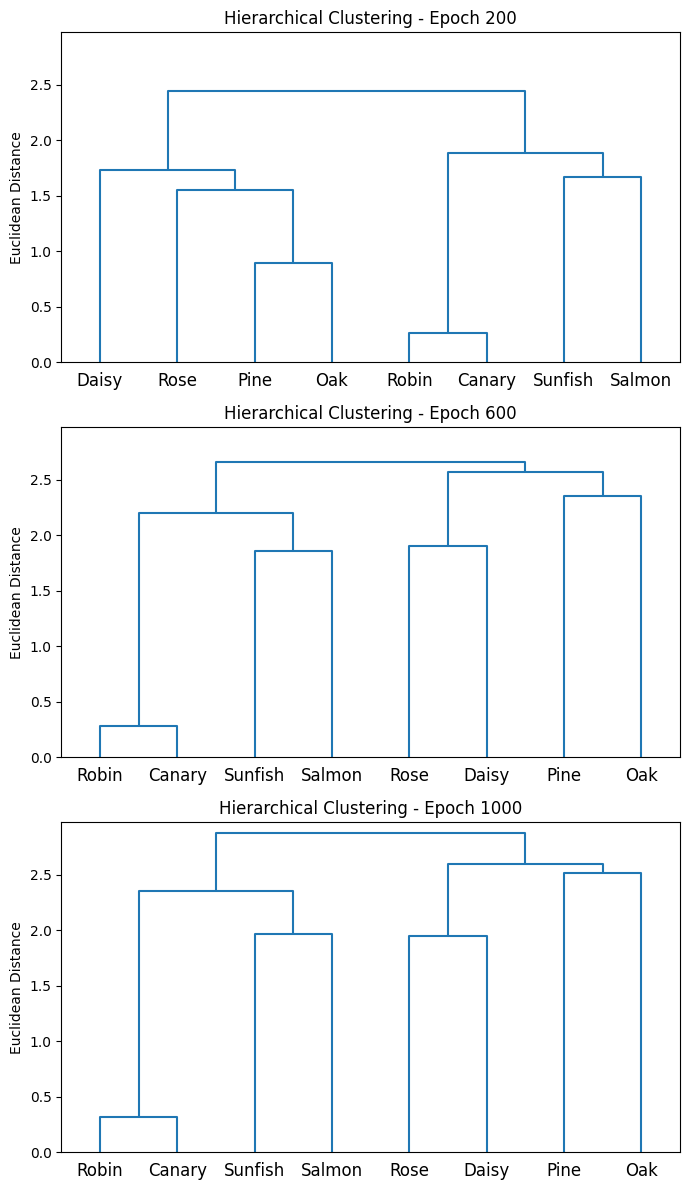

In [53]:
plot_dendo(rep1,rep2,rep3,items)